In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset paths
train_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Get class names (folder names)
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

# Create label mapping
label_map = {i: class_name for i, class_name in enumerate(class_names)}
print("Class mapping:")
for i, class_name in label_map.items():
    print(f"{i}: {class_name}")

# Create DataFrames for train and test
def create_dataframe(directory):
    data = []
    for class_label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(class_dir, filename)
                data.append({'image_path': image_path, 'label': class_label})
    return pd.DataFrame(data)

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Combine for EDA
df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\nTotal images: {len(df)}")
print(f"Number of classes: {num_classes}")
df.head()

Class mapping:
0: actinic keratosis
1: basal cell carcinoma
2: dermatofibroma
3: melanoma
4: nevus
5: pigmented benign keratosis
6: seborrheic keratosis
7: squamous cell carcinoma
8: vascular lesion

Total images: 2357
Number of classes: 9


,image_path,label
0,Skin cancer ISIC The International Skin Imagin...,0
1,Skin cancer ISIC The International Skin Imagin...,0
2,Skin cancer ISIC The International Skin Imagin...,0
3,Skin cancer ISIC The International Skin Imagin...,0
4,Skin cancer ISIC The International Skin Imagin...,0


In [4]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

# Define image size
IMG_HEIGHT = 75
IMG_WIDTH = 100

# Function to load and resize images
def load_and_resize_image(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

# Load all images
print("Loading images...")
df['image'] = df['image_path'].apply(load_and_resize_image)
df = df.dropna(subset=['image'])  # Remove failed loads
print(f"Successfully loaded {len(df)} images")

# Find the class with the maximum number of samples
max_class_size = df['label'].value_counts().max()
print(f"Majority class size: {max_class_size}")

# Create a balanced dataset by oversampling minority classes
balanced_dfs = []
for class_label in df['label'].unique():
    class_df = df[df['label'] == class_label]
    if len(class_df) < max_class_size:
        # Oversample minority classes
        oversampled_df = resample(class_df, 
                                 replace=True, 
                                 n_samples=max_class_size,
                                 random_state=42)
        balanced_dfs.append(oversampled_df)
    else:
        balanced_dfs.append(class_df)

# Combine balanced dataframes
balanced_df = pd.concat(balanced_dfs)
print(f"Balanced dataset size: {len(balanced_df)}")

# Verify new class distribution
print("\nBalanced Class Distribution:")
print(balanced_df['label'].value_counts().sort_index())

# Normalize pixel values
balanced_df['image'] = balanced_df['image'] / 255.0

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

d:\DERMAC\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Loading images...
Successfully loaded 2357 images
Majority class size: 478
Balanced dataset size: 4302

Balanced Class Distribution:
label
0    478
1    478
2    478
3    478
4    478
5    478
6    478
7    478
8    478
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Prepare data for splitting
x = np.stack(balanced_df['image'].values)
y = balanced_df['label'].values

# Convert labels to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Split into train (70%), validation (15%), and test (15%)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y_onehot, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, 
    test_size=0.5, 
    stratify=np.argmax(y_temp, axis=1), 
    random_state=42
)

# Print split information
print(f"Training set: {x_train.shape} - {len(y_train)} samples")
print(f"Validation set: {x_val.shape} - {len(y_val)} samples")
print(f"Test set: {x_test.shape} - {len(y_test)} samples")

# Verify class distribution in each split
def print_class_distribution(y_data, split_name):
    y_labels = np.argmax(y_data, axis=1)
    unique, counts = np.unique(y_labels, return_counts=True)
    print(f"\n{split_name} Class Distribution:")
    for label, count in zip(unique, counts):
        print(f"  Class {label} ({label_map[label]}): {count} samples")

print_class_distribution(y_train, "Training")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

Training set: (3011, 75, 100, 3) - 3011 samples
Validation set: (645, 75, 100, 3) - 645 samples
Test set: (646, 75, 100, 3) - 646 samples

Training Class Distribution:
  Class 0 (actinic keratosis): 335 samples
  Class 1 (basal cell carcinoma): 335 samples
  Class 2 (dermatofibroma): 334 samples
  Class 3 (melanoma): 334 samples
  Class 4 (nevus): 334 samples
  Class 5 (pigmented benign keratosis): 335 samples
  Class 6 (seborrheic keratosis): 334 samples
  Class 7 (squamous cell carcinoma): 335 samples
  Class 8 (vascular lesion): 335 samples

Validation Class Distribution:
  Class 0 (actinic keratosis): 71 samples
  Class 1 (basal cell carcinoma): 72 samples
  Class 2 (dermatofibroma): 72 samples
  Class 3 (melanoma): 72 samples
  Class 4 (nevus): 72 samples
  Class 5 (pigmented benign keratosis): 71 samples
  Class 6 (seborrheic keratosis): 72 samples
  Class 7 (squamous cell carcinoma): 71 samples
  Class 8 (vascular lesion): 72 samples

Test Class Distribution:
  Class 0 (actinic 

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model architecture
def create_model(input_shape=(75, 100, 3), num_classes=9):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
model = create_model(input_shape=(75, 100, 3), num_classes=num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

d:\DERMAC\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,444,041 (5.51 MB)

 Trainable params: 1,443,081 (5.50 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3007 - loss: 2.9546
Epoch 1: val_accuracy improved from None to 0.11938, saving model to best_skin_cancer_model.h5



Epoch 1: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.3660 - loss: 2.3722 - val_accuracy: 0.1194 - val_loss: 3.0046 - learning_rate: 0.0010
Epoch 2/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.4880 - loss: 1.5340
Epoch 2: val_accuracy improved from 0.11938 to 0.13953, saving model to best_skin_cancer_model.h5



Epoch 2: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - accuracy: 0.4852 - loss: 1.5023 - val_accuracy: 0.1395 - val_loss: 4.3164 - learning_rate: 0.0010
Epoch 3/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5622 - loss: 1.2699
Epoch 3: val_accuracy improved from 0.13953 to 0.18915, saving model to best_skin_cancer_model.h5



Epoch 3: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.5653 - loss: 1.2586 - val_accuracy: 0.1891 - val_loss: 3.0134 - learning_rate: 0.0010
Epoch 4/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6158 - loss: 1.0899
Epoch 4: val_accuracy improved from 0.18915 to 0.28992, saving model to best_skin_cancer_model.h5



Epoch 4: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.6240 - loss: 1.0688 - val_accuracy: 0.2899 - val_loss: 2.8885 - learning_rate: 0.0010
Epoch 5/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6611 - loss: 0.9891
Epoch 5: val_accuracy improved from 0.28992 to 0.49457, saving model to best_skin_cancer_model.h5



Epoch 5: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.6682 - loss: 0.9434 - val_accuracy: 0.4946 - val_loss: 1.5145 - learning_rate: 0.0010
Epoch 6/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7240 - loss: 0.8206
Epoch 6: val_accuracy did not improve from 0.49457
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.7237 - loss: 0.7976 - val_accuracy: 0.4512 - val_loss: 1.9480 - learning_rate: 0.0010
Epoch 7/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7192 - loss: 0.7984
Epoch 7: val_accuracy improved from 0.49457 to 0.60000, saving model to best_skin_cancer_model.h5



Epoch 7: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.7137 - loss: 0.8104 - val_accuracy: 0.6000 - val_loss: 1.2162 - learning_rate: 0.0010
Epoch 8/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7609 - loss: 0.6847
Epoch 8: val_accuracy did not improve from 0.60000
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.7692 - loss: 0.6594 - val_accuracy: 0.2977 - val_loss: 3.6824 - learning_rate: 0.0010
Epoch 9/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8056 - loss: 0.5759
Epoch 9: val_accuracy improved from 0.60000 to 0.67752, saving model to best_skin_cancer_model.h5



Epoch 9: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.8024 - loss: 0.5705 - val_accuracy: 0.6775 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 10/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7908 - loss: 0.5731
Epoch 10: val_accuracy did not improve from 0.67752
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.8027 - loss: 0.5532 - val_accuracy: 0.5845 - val_loss: 1.2364 - learning_rate: 0.0010
Epoch 11/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8322 - loss: 0.4692
Epoch 11: val_accuracy did not improve from 0.67752
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.8339 - loss: 0.4538 - val_accuracy: 0.4853 - val_loss: 1.8640 - learning_rate: 0.0010
Epoch 12/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8504 - loss: 0.4152
Epoch 12: val_accuracy did not improve from 0.67752

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
95/95 ━━━━━━━━━━━


Epoch 13: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.8980 - loss: 0.2862 - val_accuracy: 0.7690 - val_loss: 0.7613 - learning_rate: 2.0000e-04
Epoch 14/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9099 - loss: 0.2504
Epoch 14: val_accuracy improved from 0.76899 to 0.82946, saving model to best_skin_cancer_model.h5



Epoch 14: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9110 - loss: 0.2399 - val_accuracy: 0.8295 - val_loss: 0.5662 - learning_rate: 2.0000e-04
Epoch 15/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9341 - loss: 0.1827
Epoch 15: val_accuracy did not improve from 0.82946
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.9319 - loss: 0.1917 - val_accuracy: 0.8124 - val_loss: 0.5987 - learning_rate: 2.0000e-04
Epoch 16/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9279 - loss: 0.1864
Epoch 16: val_accuracy improved from 0.82946 to 0.83101, saving model to best_skin_cancer_model.h5



Epoch 16: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9342 - loss: 0.1773 - val_accuracy: 0.8310 - val_loss: 0.6379 - learning_rate: 2.0000e-04
Epoch 17/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9394 - loss: 0.1571
Epoch 17: val_accuracy did not improve from 0.83101

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.9396 - loss: 0.1650 - val_accuracy: 0.8310 - val_loss: 0.5801 - learning_rate: 2.0000e-04
Epoch 18/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9370 - loss: 0.1624
Epoch 18: val_accuracy improved from 0.83101 to 0.83876, saving model to best_skin_cancer_model.h5



Epoch 18: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.9412 - loss: 0.1565 - val_accuracy: 0.8388 - val_loss: 0.5664 - learning_rate: 4.0000e-05
Epoch 19/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9464 - loss: 0.1428
Epoch 19: val_accuracy improved from 0.83876 to 0.84651, saving model to best_skin_cancer_model.h5



Epoch 19: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.9425 - loss: 0.1497 - val_accuracy: 0.8465 - val_loss: 0.5724 - learning_rate: 4.0000e-05
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.


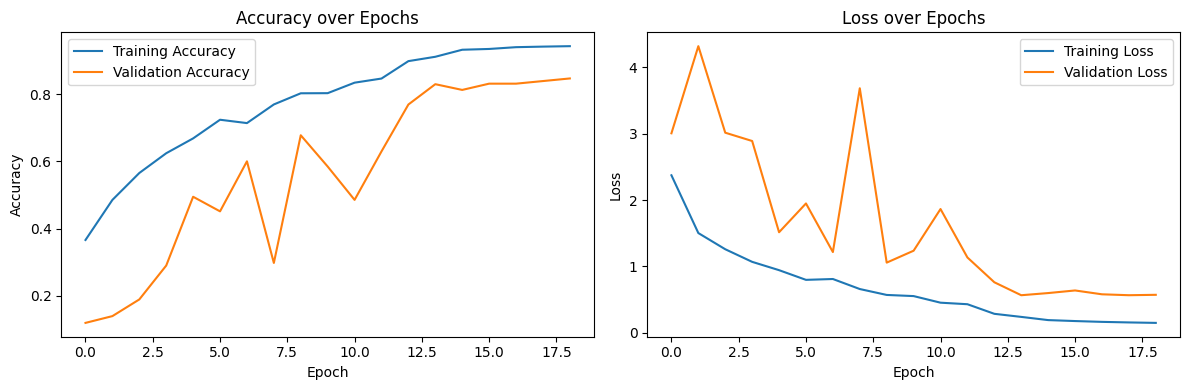

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_skin_cancer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint, reduce_lr],
    verbose=1
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

Epoch 1/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9413 - loss: 0.1824
Epoch 1: val_accuracy improved from None to 0.82636, saving model to best_skin_cancer_model.h5



Epoch 1: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.9359 - loss: 0.1921 - val_accuracy: 0.8264 - val_loss: 0.5671 - learning_rate: 4.0000e-05
Epoch 2/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9320 - loss: 0.1871
Epoch 2: val_accuracy did not improve from 0.82636
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.9329 - loss: 0.1837 - val_accuracy: 0.8248 - val_loss: 0.5730 - learning_rate: 4.0000e-05
Epoch 3/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9370 - loss: 0.1681
Epoch 3: val_accuracy did not improve from 0.82636
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.9366 - loss: 0.1703 - val_accuracy: 0.8233 - val_loss: 0.5693 - learning_rate: 4.0000e-05
Epoch 4/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9410 - loss: 0.1588
Epoch 4: val_accuracy did not improve from 0.82636

Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
95/95 ━━━━━━━


Epoch 5: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.9455 - loss: 0.1598 - val_accuracy: 0.8372 - val_loss: 0.5624 - learning_rate: 8.0000e-06
Epoch 6/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9413 - loss: 0.1580
Epoch 6: val_accuracy did not improve from 0.83721
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.9382 - loss: 0.1648 - val_accuracy: 0.8357 - val_loss: 0.5593 - learning_rate: 8.0000e-06
Epoch 7/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9475 - loss: 0.1449
Epoch 7: val_accuracy did not improve from 0.83721
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - accuracy: 0.9429 - loss: 0.1527 - val_accuracy: 0.8341 - val_loss: 0.5622 - learning_rate: 8.0000e-06
Epoch 8/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9390 - loss: 0.1757
Epoch 8: val_accuracy improved from 0.83721 to 0.84186, saving model to best_skin_cancer_model.h5



Epoch 8: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.9402 - loss: 0.1639 - val_accuracy: 0.8419 - val_loss: 0.5617 - learning_rate: 8.0000e-06
Epoch 9/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9434 - loss: 0.1554
Epoch 9: val_accuracy improved from 0.84186 to 0.84651, saving model to best_skin_cancer_model.h5



Epoch 9: finished saving model to best_skin_cancer_model.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9406 - loss: 0.1581 - val_accuracy: 0.8465 - val_loss: 0.5579 - learning_rate: 8.0000e-06
Epoch 10/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9451 - loss: 0.1504
Epoch 10: val_accuracy did not improve from 0.84651
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.9462 - loss: 0.1515 - val_accuracy: 0.8403 - val_loss: 0.5624 - learning_rate: 8.0000e-06
Epoch 11/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9384 - loss: 0.1500
Epoch 11: val_accuracy did not improve from 0.84651
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.9372 - loss: 0.1559 - val_accuracy: 0.8388 - val_loss: 0.5637 - learning_rate: 8.0000e-06
Epoch 12/30
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9462 - loss: 0.1394
Epoch 12: val_accuracy did not improve from 0.84651

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
95/95

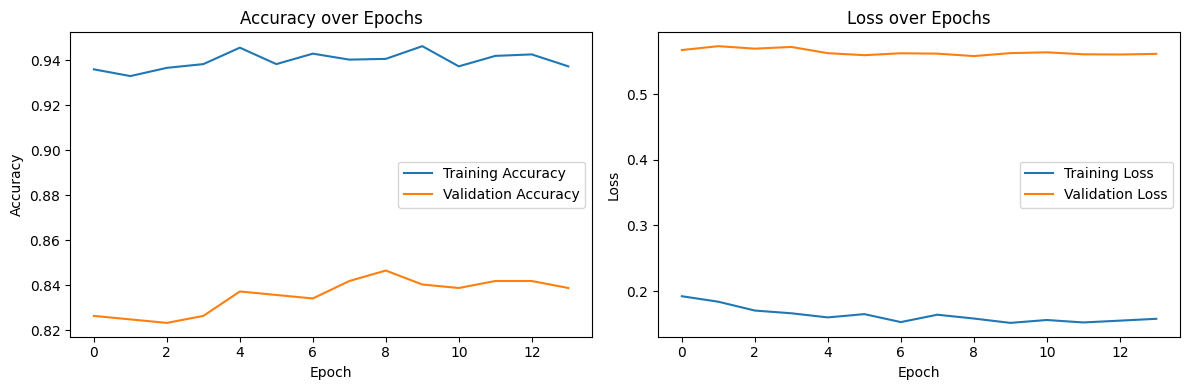

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_skin_cancer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint, reduce_lr],
    verbose=1
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

Test Accuracy: 0.8653
Test Loss: 0.4758
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.81      0.93      0.86        72
      basal cell carcinoma       0.93      0.87      0.90        71
            dermatofibroma       0.96      0.96      0.96        72
                  melanoma       0.82      0.64      0.72        72
                     nevus       0.88      0.78      0.82        72
pigmented benign keratosis       0.86      0.75      0.80        72
      seborrheic keratosis       0.80      0.92      0.85        72
   squamous cell carcinoma       0.79      0.94      0.86        72
           vascular lesion       0.99      1.00      0.99        71

                  accuracy                           0.87       646
                 macro avg       0.87      0.87      0.86       646
              weighted avg       0.87      0.87      0.86       646



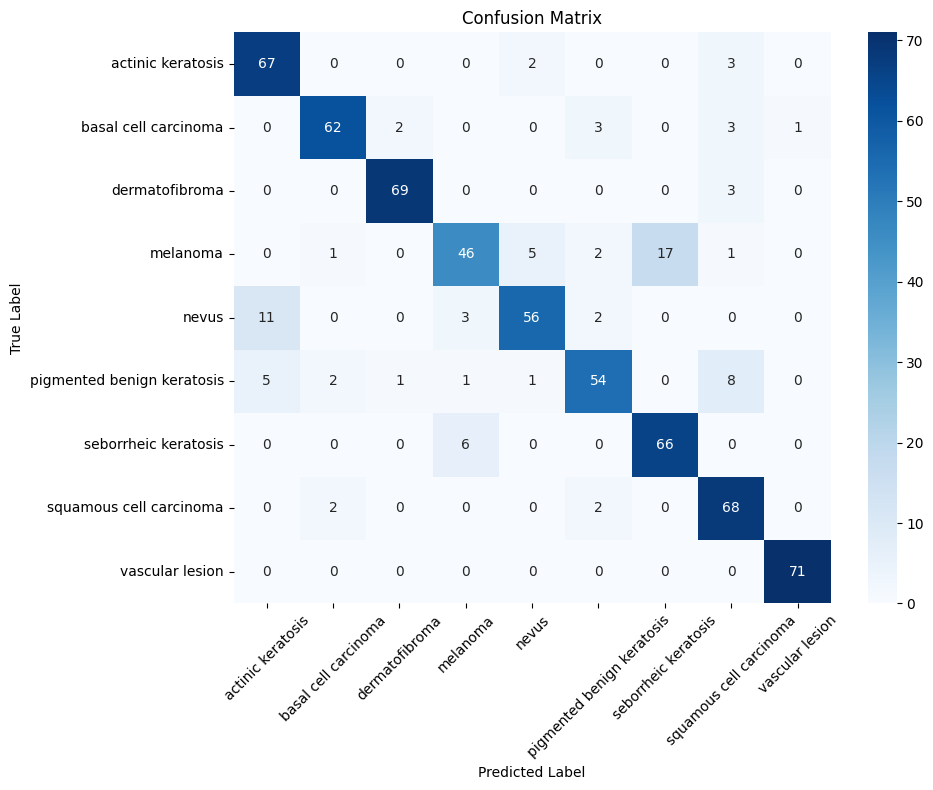

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Load the best model
from tensorflow.keras.models import load_model
best_model = load_model('best_skin_cancer_model.h5')

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_map.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
# Load our best model (custom CNN)
best_model = load_model('best_skin_cancer_model.h5')

# Convert to TensorFlow Lite for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Apply quantization to reduce size and improve inference speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: Further reduce size with float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Convert the model
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('dermac_ai_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Check model size
model_size = os.path.getsize('dermac_ai_model.tflite') / (1024 * 1024)  # MB
print(f"Model Size: {model_size:.2f} MB")

# Test inference time
import time
interpreter = tf.lite.Interpreter(model_path='dermac_ai_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test with a sample image
sample_image = np.expand_dims(x_test[0], axis=0).astype('float32')
interpreter.set_tensor(input_details[0]['index'], sample_image)

# Measure inference time
start_time = time.time()
interpreter.invoke()
inference_time = time.time() - start_time

print(f"Inference Time: {inference_time:.4f} seconds")

# Get prediction
prediction = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(prediction)
print(f"Predicted Class: {predicted_class} ({label_map[predicted_class]})")
print(f"Actual Class: {np.argmax(y_test[0])} ({label_map[np.argmax(y_test[0])]})")

# Verify model performance on test set
# Fix the evaluation function - convert input to FLOAT32
def evaluate_tflite_model(interpreter, x_test, y_test):
    correct_predictions = 0
    total_predictions = len(x_test)
    
    for i in range(total_predictions):
        # Convert input to FLOAT32 and add batch dimension
        input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)
        
        # Set input
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        interpreter.invoke()
        
        # Get prediction
        prediction = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(prediction)
        actual_class = np.argmax(y_test[i])
        
        if predicted_class == actual_class:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_predictions
    return accuracy

# Evaluate the TFLite model
tflite_accuracy = evaluate_tflite_model(interpreter, x_test, y_test)
print(f"TFLite Model Accuracy: {tflite_accuracy:.4f}")

# Compare with original model
print(f"Original Model Accuracy: {test_acc:.4f}")
print(f"Accuracy Difference: {abs(test_acc - tflite_accuracy):.4f}")

INFO:tensorflow:Assets written to: C:\Users\SOUMYA~1\AppData\Local\Temp\tmpt67mnvv1\assets


INFO:tensorflow:Assets written to: C:\Users\SOUMYA~1\AppData\Local\Temp\tmpt67mnvv1\assets


Saved artifact at 'C:\Users\SOUMYA~1\AppData\Local\Temp\tmpt67mnvv1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 100, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  2141582791440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582790864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582800464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582796240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582799888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582801424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582801232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582797968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582789712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141582797584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2141

d:\DERMAC\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


TFLite Model Accuracy: 0.8653
Original Model Accuracy: 0.8653
Accuracy Difference: 0.0000


Comparing uploaded images with training data...

Training Data Characteristics (Sample):
Training Brightness: 154.05 ± 18.99
Training Contrast: 41.52 ± 9.32
Training Edge Density: 0.0884 ± 0.0843

Testing preprocessing on training data...
True Class: vascular lesion
Predicted Class: vascular lesion
Confidence: 99.99%


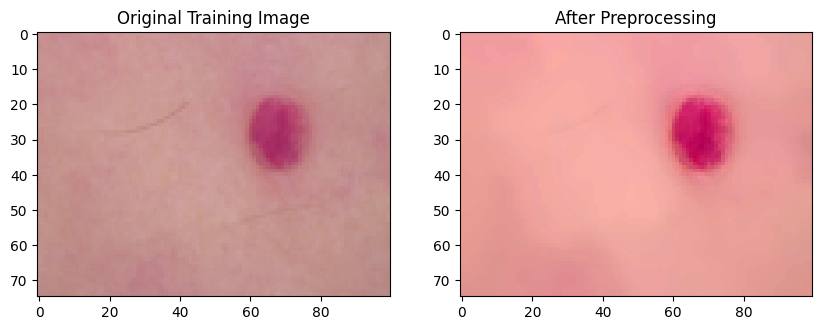

In [17]:
import cv2
import numpy as np
from PIL import Image as PILImage
import ipywidgets as widgets
from IPython.display import display, Image, HTML
import io
import tensorflow as tf
# First, let's analyze what makes these images different
def advanced_image_analysis(img):
    """Perform advanced analysis of image characteristics."""
    # Convert to numpy array
    img_array = np.array(img)
    
    # Basic stats
    brightness = np.mean(img_array)
    contrast = np.std(img_array)
    
    # Color distribution
    r_hist = np.histogram(img_array[:,:,0], bins=256)[0]
    g_hist = np.histogram(img_array[:,:,1], bins=256)[0]
    b_hist = np.histogram(img_array[:,:,2], bins=256)[0]
    
    # Edge density (as a proxy for image sharpness/detail)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / edges.size
    
    # Texture analysis using Local Binary Pattern
    try:
        from skimage.feature import local_binary_pattern
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=n_points + 2)
        lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize
    except:
        lbp_hist = np.zeros(10)
    
    return {
        'brightness': brightness,
        'contrast': contrast,
        'edge_density': edge_density,
        'r_hist': r_hist,
        'g_hist': g_hist,
        'b_hist': b_hist,
        'lbp_hist': lbp_hist,
        'size': img.size
    }

# Compare with training data
print("Comparing uploaded images with training data...")
print("\nTraining Data Characteristics (Sample):")
train_sample = x_train[:100]  # Sample of training data

# Calculate training data stats
train_brightness = []
train_contrast = []
train_edge_density = []

for i in range(0, len(train_sample), 10):
    img_array = (train_sample[i] * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    train_brightness.append(np.mean(img_array))
    train_contrast.append(np.std(img_array))
    
    edges = cv2.Canny(gray, 50, 150)
    train_edge_density.append(np.sum(edges > 0) / edges.size)

print(f"Training Brightness: {np.mean(train_brightness):.2f} ± {np.std(train_brightness):.2f}")
print(f"Training Contrast: {np.mean(train_contrast):.2f} ± {np.std(train_contrast):.2f}")
print(f"Training Edge Density: {np.mean(train_edge_density):.4f} ± {np.std(train_edge_density):.4f}")

# Now let's create a more sophisticated preprocessing pipeline
def advanced_preprocessing(img):
    """Advanced preprocessing to match training data characteristics."""
    # Convert to RGB if needed
    if img.mode == 'RGBA':
        background = PILImage.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # 1. Resize to standard size while maintaining aspect ratio
    h, w = img_array.shape[:2]
    target_ratio = 100 / 75  # Model input ratio
    
    if w / h > target_ratio:
        # Image is wider - crop width
        new_w = int(h * target_ratio)
        left = (w - new_w) // 2
        img_array = img_array[:, left:left+new_w, :]
    else:
        # Image is taller - crop height
        new_h = int(w / target_ratio)
        top = (h - new_h) // 2
        img_array = img_array[top:top+new_h, :, :]
    
    # 2. Apply histogram matching to training data
    # This is more sophisticated than simple brightness/contrast adjustment
    try:
        from skimage.exposure import match_histograms
        
        # Use a reference image from training data
        reference = (x_train[0] * 255).astype(np.uint8)
        img_array = match_histograms(img_array, reference, multichannel=True)
    except:
        # Fallback to simple normalization
        img_array = cv2.normalize(img_array, None, 0, 255, cv2.NORM_MINMAX)
    
    # 3. Apply mild denoising if needed
    img_array = cv2.fastNlMeansDenoisingColored(img_array, None, 3, 3, 7, 21)
    
    # 4. Convert back to PIL and resize to model input
    img = PILImage.fromarray(img_array)
    img = img.resize((100, 75))
    
    return img

# Update the prediction function
def enhanced_predict(img):
    """Enhanced prediction with advanced preprocessing."""
    # Apply advanced preprocessing
    processed_img = advanced_preprocessing(img)
    
    # Convert to array and normalize
    img_array = np.array(processed_img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    
    # Make prediction
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])
    
    return prediction, processed_img

# Test with a sample from training data to verify preprocessing works
print("\nTesting preprocessing on training data...")
sample_idx = 0
train_img = (x_train[sample_idx] * 255).astype(np.uint8)
train_pil = PILImage.fromarray(train_img)

# Process and predict
prediction, processed_img = enhanced_predict(train_pil)
predicted_class = np.argmax(prediction)
true_class = np.argmax(y_train[sample_idx])

print(f"True Class: {label_map[true_class]}")
print(f"Predicted Class: {label_map[predicted_class]}")
print(f"Confidence: {np.max(prediction):.2%}")

# Display the processed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_img)
plt.title('Original Training Image')
plt.subplot(1, 2, 2)
plt.imshow(processed_img)
plt.title('After Preprocessing')
plt.show()

In [19]:
import ipywidgets as widgets
from IPython.display import display, Image, HTML
import numpy as np
from PIL import Image as PILImage
import io
import cv2
import tensorflow as tf
import traceback

# Load the TFLite model
print("Loading model...")
interpreter = tf.lite.Interpreter(model_path='dermac_ai_model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Model loaded successfully!")

# Multiple preprocessing methods
def preprocess_method1(img):
    """Method 1: Simple normalization"""
    try:
        # Convert to RGB
        if img.mode == 'RGBA':
            background = PILImage.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])
            img = background
        
        # Resize to model input
        img = img.resize((100, 75))
        img_array = np.array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Method 1 error: {e}")
        return None

def preprocess_method2(img):
    """Method 2: Histogram matching"""
    try:
        # Convert to RGB
        if img.mode == 'RGBA':
            background = PILImage.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])
            img = background
        
        # Convert to array
        img_array = np.array(img)
        
        # Histogram matching with training data reference
        try:
            reference = (x_train[0] * 255).astype(np.uint8)
            from skimage.exposure import match_histograms
            img_array = match_histograms(img_array, reference, multichannel=True)
        except Exception as hist_error:
            print(f"Histogram matching failed: {hist_error}")
            # Fallback to simple normalization
            img_array = cv2.normalize(img_array, None, 0, 255, cv2.NORM_MINMAX)
        
        # Resize
        img = PILImage.fromarray(img_array)
        img = img.resize((100, 75))
        img_array = np.array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Method 2 error: {e}")
        return None

def preprocess_method3(img):
    """Method 3: CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
    try:
        # Convert to RGB
        if img.mode == 'RGBA':
            background = PILImage.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3])
            img = background
        
        # Convert to array
        img_array = np.array(img)
        
        # Apply CLAHE to LAB color space
        lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        lab[:,:,0] = clahe.apply(lab[:,:,0])
        img_array = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        # Resize
        img = PILImage.fromarray(img_array)
        img = img.resize((100, 75))
        img_array = np.array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Method 3 error: {e}")
        return None

def ensemble_predict(img):
    """Make ensemble prediction using multiple preprocessing methods."""
    print("Starting ensemble prediction...")
    
    # Get predictions from each method
    methods = [preprocess_method1, preprocess_method2, preprocess_method3]
    predictions = []
    valid_methods = []
    
    for i, method in enumerate(methods):
        print(f"Trying method {i+1}...")
        try:
            # Preprocess
            img_array = method(img)
            if img_array is None:
                print(f"Method {i+1} returned None")
                continue
                
            print(f"Method {i+1} preprocessing successful")
            print(f"  Array shape: {img_array.shape}")
            print(f"  Array dtype: {img_array.dtype}")
            print(f"  Array range: [{img_array.min():.3f}, {img_array.max():.3f}]")
            
            # Add batch dimension
            img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
            
            # Predict
            interpreter.set_tensor(input_details[0]['index'], img_array)
            interpreter.invoke()
            pred = interpreter.get_tensor(output_details[0]['index'])
            predictions.append(pred[0])
            valid_methods.append(i+1)
            
            print(f"Method {i+1} prediction successful")
            print(f"  Prediction shape: {pred.shape}")
            
        except Exception as e:
            print(f"Method {i+1} failed: {e}")
            traceback.print_exc()
    
    if len(predictions) == 0:
        print("All methods failed!")
        return np.zeros(9)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    print(f"Ensemble prediction created from {len(predictions)} methods")
    return ensemble_pred

# Create widgets
upload_btn = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',
    multiple=False,
    description='Upload Image',
    style={'description_width': 'initial'}
)

predict_btn = widgets.Button(
    description='Predict',
    button_style='primary',
    disabled=True
)

# Output widgets
output_img = widgets.Output()
output_pred = widgets.Output()
output_debug = widgets.Output()
output_methods = widgets.Output()

# Global variable to store uploaded image
uploaded_image = None

def detect_skin(image, threshold=0.15):
    """Detect if an image contains skin using HSV color space."""
    try:
        img_array = np.array(image)
        hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
        
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
        skin_pixels = np.count_nonzero(mask)
        total_pixels = mask.size
        skin_ratio = skin_pixels / total_pixels
        
        return skin_ratio >= threshold, skin_ratio
    except Exception as e:
        print(f"Skin detection error: {e}")
        return False, 0

def on_upload_change(change):
    """Handle file upload."""
    global uploaded_image
    
    with output_debug:
        output_debug.clear_output()
        print("Upload triggered")
    
    if not change['new']:
        with output_debug:
            print("No file uploaded")
        predict_btn.disabled = True
        return
    
    try:
        file_info = change['new'][0]
        content = file_info['content']
        name = file_info['name']
        
        with output_debug:
            print(f"File name: {name}")
        
        # Open the image
        img = PILImage.open(io.BytesIO(content))
        
        with output_debug:
            print(f"Original image mode: {img.mode}")
            print(f"Original image size: {img.size}")
        
        uploaded_image = img
        
        # Display the image
        with output_img:
            output_img.clear_output()
            display(img)
        
        # Enable predict button
        predict_btn.disabled = False
        
        with output_debug:
            print(f"Image uploaded successfully. Size: {img.size}")
            print("Predict button enabled")
    except Exception as e:
        with output_debug:
            print(f"Error processing upload: {e}")
            traceback.print_exc()
        predict_btn.disabled = False

def on_predict_click(b):
    """Handle prediction button click."""
    with output_pred:
        output_pred.clear_output()
        print("Prediction started...")
    
    if uploaded_image is None:
        with output_pred:
            print("Please upload an image first")
        return
    
    try:
        # Step 1: Check if image contains skin
        with output_pred:
            print("Step 1: Detecting skin...")
        
        is_skin, skin_ratio = detect_skin(uploaded_image)
        
        with output_pred:
            print(f"Skin Detection: {'PASS' if is_skin else 'FAIL'}")
            print(f"Skin Pixel Ratio: {skin_ratio:.2%}")
        
        if not is_skin:
            with output_pred:
                print("❌ This image does not appear to contain skin.")
                print("Please upload an image of a skin lesion.")
            return
        
        # Step 2: Make ensemble prediction
        with output_pred:
            print("\nStep 2: Making ensemble prediction...")
        
        ensemble_pred = ensemble_predict(uploaded_image)
        
        # Get individual method predictions for comparison
        with output_pred:
            print("\nStep 3: Getting individual method predictions...")
        
        methods = [preprocess_method1, preprocess_method2, preprocess_method3]
        method_preds = []
        
        for i, method in enumerate(methods):
            try:
                with output_pred:
                    print(f"\nProcessing method {i+1}...")
                
                img_array = method(uploaded_image)
                if img_array is None:
                    with output_pred:
                        print(f"Method {i+1} failed to preprocess")
                    method_preds.append(np.zeros(9))
                    continue
                
                img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
                
                interpreter.set_tensor(input_details[0]['index'], img_array)
                interpreter.invoke()
                pred = interpreter.get_tensor(output_details[0]['index'])
                method_preds.append(pred[0])
                
                with output_pred:
                    print(f"Method {i+1} completed successfully")
                    
            except Exception as e:
                with output_pred:
                    print(f"Method {i+1} error: {e}")
                    traceback.print_exc()
                method_preds.append(np.zeros(9))
        
        # Display results
        predicted_class = np.argmax(ensemble_pred)
        confidence = np.max(ensemble_pred)
        
        with output_pred:
            print(f"\n=== FINAL RESULTS ===")
            print(f"Ensemble Prediction:")
            print(f"Predicted Class: {label_map[predicted_class]}")
            print(f"Confidence: {confidence:.2%}")
            print("\nClass Probabilities:")
            for i, prob in enumerate(ensemble_pred):
                print(f"  {label_map[i]}: {prob:.2%}")
        
        # Display individual method predictions
        with output_methods:
            output_methods.clear_output()
            print("Individual Method Predictions:")
            method_names = ["Simple Normalization", "Histogram Matching", "CLAHE"]
            for i, (pred, name) in enumerate(zip(method_preds, method_names)):
                pred_class = np.argmax(pred)
                pred_conf = np.max(pred)
                print(f"\n{name}:")
                print(f"  Predicted: {label_map[pred_class]} ({pred_conf:.2%})")
                print(f"  Top 3: ", end="")
                top3 = np.argsort(pred)[-3:][::-1]
                for j in top3:
                    print(f"{label_map[j]} ({pred[j]:.1%}) ", end="")
                print()
    
    except Exception as e:
        with output_pred:
            print(f"Error during prediction: {e}")
            traceback.print_exc()

# Set up event handlers
upload_btn.observe(on_upload_change, names='value')
predict_btn.on_click(on_predict_click)

# Display the interface
display(HTML("<h2>SAGAlyze Skin Lesion Classifier - Ensemble Version (Debug)</h2>"))
display(HTML("<p>Upload a skin lesion image and click Predict:</p>"))
display(widgets.HBox([upload_btn, predict_btn]))
display(HTML("<h3>Uploaded Image:</h3>"))
display(output_img)
display(HTML("<h3>Ensemble Prediction:</h3>"))
display(output_pred)
display(HTML("<h3>Individual Method Predictions:</h3>"))
display(output_methods)
display(HTML("<h3>Debug Info:</h3>"))
display(output_debug)
print("⚠ Important Disclaimer: This is an AI-assisted advisory tool only. Always consult with a qualified dermatologist for diagnosis and treatment decisions. The model may have limitations in performance across different skin tones.")

Loading model...
Model loaded successfully!


Output()

Output()

Output()

Output()

⚠ Important Disclaimer: This is an AI-assisted advisory tool only. Always consult with a qualified dermatologist for diagnosis and treatment decisions. The model may have limitations in performance across different skin tones.


Testing progress tracking functionality...


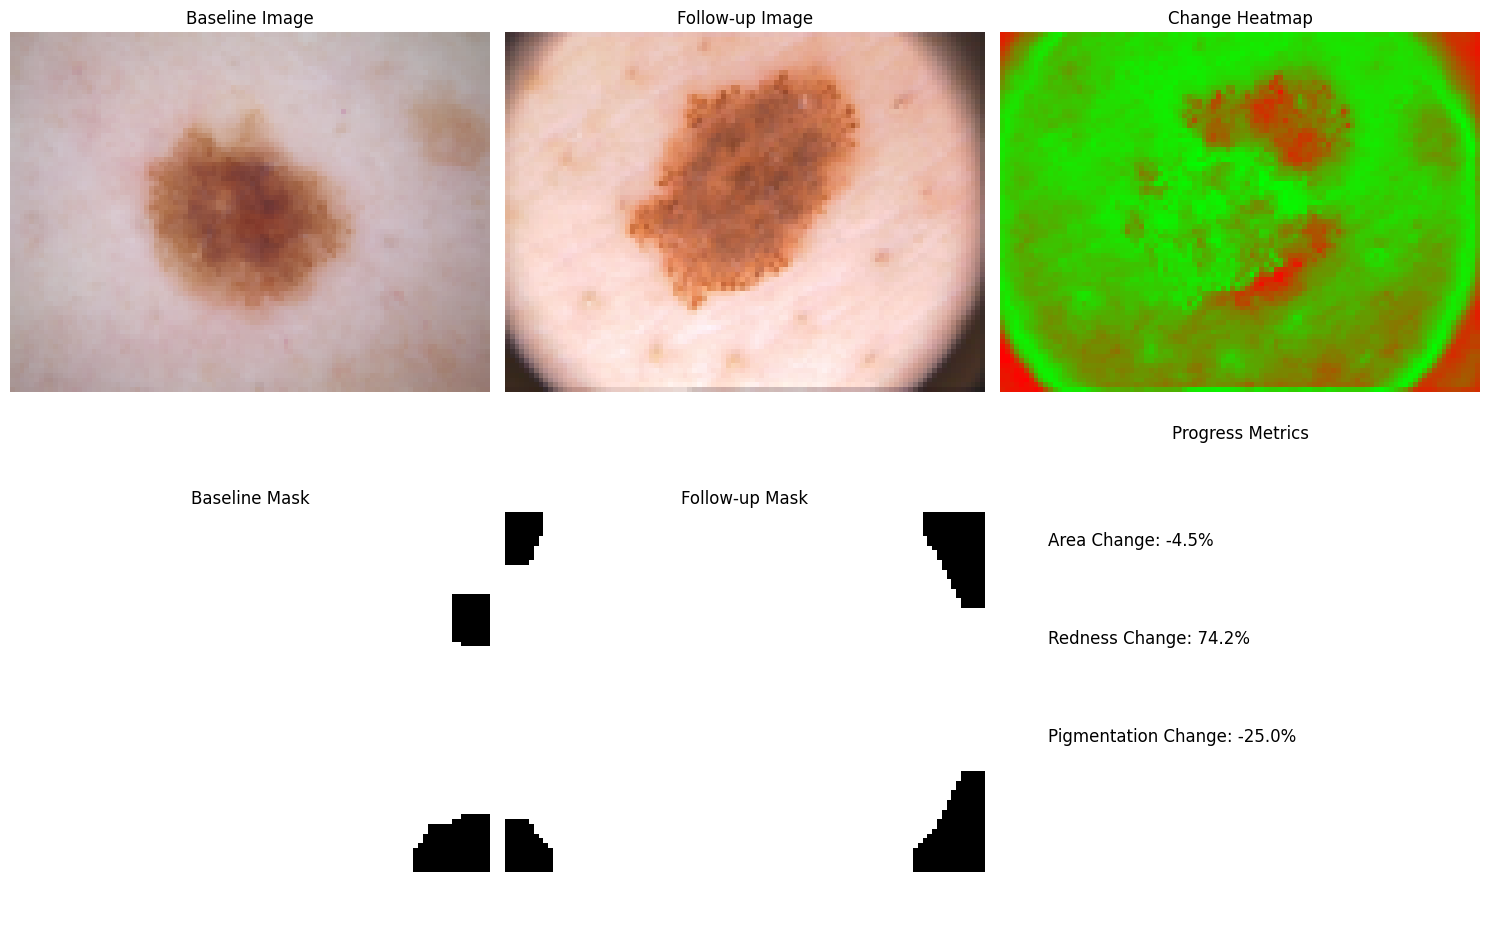

Progress tracking metrics:
- Area change: -4.47%
- Redness change: 74.18%
- Pigmentation change: -24.99%

Interpretation:
Significant redness change detected
Significant pigmentation change detected

Progress tracking functionality implemented successfully!


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class ProgressTracker:
    def __init__(self):  # Fixed: double underscores and removed model parameter
        # Class labels mapping
        self.label_map = {
            0: "Actinic Keratosis",
            1: "Basal Cell Carcinoma", 
            2: "Dermatofibroma",
            3: "Melanoma",
            4: "Nevus",
            5: "Pigmented Benign Keratosis",
            6: "Seborrheic Keratosis", 
            7: "Squamous Cell Carcinoma",
            8: "Vascular Lesion"
        }
        
    def register_images(self, img1, img2):
        """Register img2 to img1 using feature-based registration"""
        # Convert to grayscale
        gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
        
        # Detect ORB features
        orb = cv2.ORB_create(nfeatures=1000)
        kp1, des1 = orb.detectAndCompute(gray1, None)
        kp2, des2 = orb.detectAndCompute(gray2, None)
        
        # Match features
        if des1 is not None and des2 is not None:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(des1, des2)
            
            # Sort matches by distance
            matches = sorted(matches, key=lambda x: x.distance)
            
            # Extract matched keypoints
            if len(matches) > 10:
                src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                
                # Find homography
                M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
                
                if M is not None:
                    # Apply transformation
                    h, w = img1.shape[:2]
                    registered_img2 = cv2.warpPerspective(img2, M, (w, h))
                    return registered_img2, M
        
        # If not enough matches or homography failed, return original image
        return img2, None
    
    def segment_lesion(self, image):
        """Segment lesion using simple thresholding and morphological operations"""
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Thresholding
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Morphological operations
        kernel = np.ones((5, 5), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # Find contours
        contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create mask
        mask = np.zeros_like(gray)
        if contours:
            # Find largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        
        return mask
    
    def calculate_redness_index(self, image, mask):
        """Calculate redness index from RGB values"""
        # Convert to float
        img_float = image.astype(np.float32) / 255.0
        
        # Extract channels
        R = img_float[:, :, 0]
        G = img_float[:, :, 1]
        B = img_float[:, :, 2]
        
        # Calculate redness index (simplified)
        if np.sum(mask > 0) > 0:
            redness = np.mean(R[mask > 0]) - np.mean(G[mask > 0])
        else:
            redness = 0
        
        return redness
    
    def calculate_pigmentation_index(self, image, mask):
        """Calculate pigmentation index"""
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        L = lab[:, :, 0] / 255.0  # Lightness
        
        # Calculate pigmentation as inverse of lightness
        if np.sum(mask > 0) > 0:
            pigmentation = 1.0 - np.mean(L[mask > 0])
        else:
            pigmentation = 0
        
        return pigmentation
    
    def calculate_metrics(self, img1, img2):
        """Calculate progress metrics between two images"""
        # Register images
        registered_img2, M = self.register_images(img1, img2)
        
        # Segment lesions
        mask1 = self.segment_lesion(img1)
        mask2 = self.segment_lesion(registered_img2)
        
        # Calculate area change
        area1 = np.sum(mask1 > 0)
        area2 = np.sum(mask2 > 0)
        area_change = ((area2 - area1) / area1 * 100) if area1 > 0 else 0
        
        # Calculate redness change
        redness1 = self.calculate_redness_index(img1, mask1)
        redness2 = self.calculate_redness_index(registered_img2, mask2)
        redness_change = ((redness2 - redness1) / abs(redness1) * 100) if redness1 != 0 else 0
        
        # Calculate pigmentation change
        pigmentation1 = self.calculate_pigmentation_index(img1, mask1)
        pigmentation2 = self.calculate_pigmentation_index(registered_img2, mask2)
        pigmentation_change = ((pigmentation2 - pigmentation1) / abs(pigmentation1) * 100) if pigmentation1 != 0 else 0
        
        return {
            'area_change': area_change,
            'redness_change': redness_change,
            'pigmentation_change': pigmentation_change,
            'mask1': mask1,
            'mask2': mask2,
            'registered_img2': registered_img2
        }
    
    def generate_heatmap_delta(self, img1, img2, mask1, mask2):
        """Generate heatmap showing changes between images"""
        # Create difference image
        diff = cv2.absdiff(img1, img2)
        gray_diff = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
        
        # Normalize the difference
        gray_diff = cv2.normalize(gray_diff, None, 0, 255, cv2.NORM_MINMAX)
        
        # Create heatmap
        heatmap = np.zeros_like(img1)
        
        # Red for positive changes, green for negative changes
        # This is a simplified version
        heatmap[:, :, 0] = gray_diff  # Red channel
        heatmap[:, :, 1] = 255 - gray_diff  # Green channel
        heatmap[:, :, 2] = 0  # Blue channel
        
        return heatmap

# Test progress tracking
print("Testing progress tracking functionality...")

# Create progress tracker instance
tracker = ProgressTracker()  # Fixed: no arguments

# Get two sample images from the same class (nevus - class 4)
nevus_indices = [i for i in range(len(x_test)) if np.argmax(y_test[i]) == 4]

if len(nevus_indices) >= 2:
    # Get two different nevus images
    img1_idx, img2_idx = nevus_indices[0], nevus_indices[1]
    
    # Convert to uint8 (0-255 range)
    img1 = (x_test[img1_idx] * 255).astype(np.uint8)
    img2 = (x_test[img2_idx] * 255).astype(np.uint8)
    
    # Calculate metrics
    metrics = tracker.calculate_metrics(img1, img2)
    
    # Generate heatmap
    heatmap = tracker.generate_heatmap_delta(img1, metrics['registered_img2'], 
                                          metrics['mask1'], metrics['mask2'])
    
    # Display results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Images
    axes[0, 0].imshow(img1)
    axes[0, 0].set_title("Baseline Image")
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(metrics['registered_img2'])
    axes[0, 1].set_title("Follow-up Image")
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(heatmap)
    axes[0, 2].set_title("Change Heatmap")
    axes[0, 2].axis('off')
    
    # Row 2: Masks and metrics
    axes[1, 0].imshow(metrics['mask1'], cmap='gray')
    axes[1, 0].set_title("Baseline Mask")
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(metrics['mask2'], cmap='gray')
    axes[1, 1].set_title("Follow-up Mask")
    axes[1, 1].axis('off')
    
    # Display metrics
    axes[1, 2].text(0.1, 0.8, f"Area Change: {metrics['area_change']:.1f}%", fontsize=12)
    axes[1, 2].text(0.1, 0.6, f"Redness Change: {metrics['redness_change']:.1f}%", fontsize=12)
    axes[1, 2].text(0.1, 0.4, f"Pigmentation Change: {metrics['pigmentation_change']:.1f}%", fontsize=12)
    axes[1, 2].set_title("Progress Metrics")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Progress tracking metrics:")
    print(f"- Area change: {metrics['area_change']:.2f}%")
    print(f"- Redness change: {metrics['redness_change']:.2f}%")
    print(f"- Pigmentation change: {metrics['pigmentation_change']:.2f}%")
    
    # Interpretation
    print("\nInterpretation:")
    if abs(metrics['area_change']) > 10:
        print("Significant size change detected")
    if abs(metrics['redness_change']) > 15:
        print("Significant redness change detected")
    if abs(metrics['pigmentation_change']) > 15:
        print("Significant pigmentation change detected")
    
else:
    print("Not enough nevus samples for progress tracking test")

print("\nProgress tracking functionality implemented successfully!")